In [20]:
import numpy as np
import cv2
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import os
from scipy.ndimage import gaussian_filter

In [2]:
import numpy as np

def gaussian_kernel(size, sigma=1.0):
    """Create a Gaussian kernel."""
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (kernel_1D[i] / sigma) ** 2)

    kernel_2D = np.outer(kernel_1D, kernel_1D)
    return kernel_2D / np.sum(kernel_2D)


In [3]:
def convolve_2d(image, kernel):
    """Apply 2D convolution using a given kernel."""
    image_height, image_width = image.shape
    kernel_size = kernel.shape[0]
    pad_size = kernel_size // 2
    
    # Pad the image with zeros on the border
    padded_image = np.pad(image, pad_size, mode='constant')

    # Initialize output image
    output_image = np.zeros_like(image)

    # Perform convolution
    for i in range(image_height):
        for j in range(image_width):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            output_image[i, j] = np.sum(region * kernel)
    
    return output_image


In [5]:
def downsample(image):
    return image[::2, ::2]


In [29]:
def upsample(image, target_shape):
    # Get the dimensions of the original image
    rows, cols = image.shape
    
    # Create a new image that is double the size in each dimension
    upsampled_image = np.zeros((2 * rows, 2 * cols))
    
    # Place the original image values into the new upsampled image
    upsampled_image[::2, ::2] = image  # Every other row and column
    
    # Smooth the upsampled image to fill in the gaps (you can tune sigma as needed)
    upsampled_image = gaussian_filter(upsampled_image, sigma=1)
    
    # Ensure the upsampled image matches the target shape by cropping it
    upsampled_image = upsampled_image[:target_shape[0], :target_shape[1]]
    
    return upsampled_image


In [30]:
def gaussian_pyramid(image, num_layers, kernel_size=5, sigma=1.0):
    pyramid = [image]  # Start with the original image
    kernel = gaussian_kernel(kernel_size, sigma)
    
    for _ in range(num_layers):
        smoothed_image = convolve_2d(pyramid[-1], kernel)  # Apply Gaussian smoothing
        downsampled_image = downsample(smoothed_image)     # Downsample the image
        pyramid.append(downsampled_image)
    
    return pyramid


In [40]:
def laplacian_pyramid(gaussian_pyr):
    laplacian_pyr = []
    for i in range(len(gaussian_pyr) - 1):
        # Upsample the next level and ensure it matches the current level's shape
        upsampled = upsample(gaussian_pyr[i + 1], gaussian_pyr[i].shape)
        # Subtract the upsampled image from the current level
        laplacian = gaussian_pyr[i] - upsampled
        laplacian_pyr.append(laplacian)
    laplacian_pyr.append(gaussian_pyr[-1])  # Add the smallest Gaussian as the last level
    return laplacian_pyr

In [32]:
def nearest_power_of_2(n):
    return 2 ** int(np.ceil(np.log2(n)))


In [33]:
from scipy.ndimage import zoom

def resize_to_power_of_2(image):
    """Resize the image dimensions to the nearest power of 2."""
    height, width = image.shape[:2]
    
    # Compute nearest power of 2 for both dimensions
    new_height = nearest_power_of_2(height)
    new_width = nearest_power_of_2(width)
    
    # Compute the resizing factors for height and width
    height_factor = new_height / height
    width_factor = new_width / width
    
    # Use zoom to resize the image
    resized_image = zoom(image, (height_factor, width_factor))
    
    return resized_image


In [34]:
from skimage import io, color

image = io.imread('./data/task1and2_hybrid_pyramid/1_bicycle.bmp')

image_gray = color.rgb2gray(image)


In [35]:
resized_image = resize_to_power_of_2(image)

RuntimeError: sequence argument must have length equal to input rank

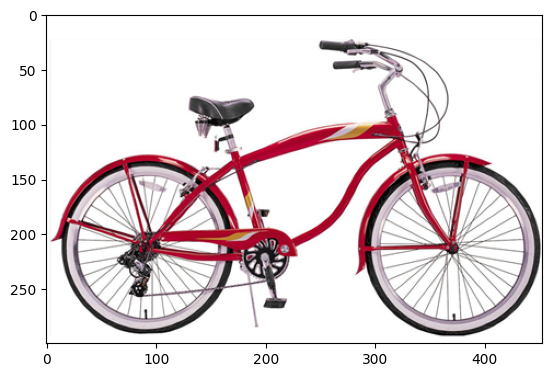

In [36]:
plt.imshow(image)

In [42]:
def plot_pyramids(gaussian_pyr, fourier_pyr):
    num_levels = len(gaussian_pyr)
    
    plt.figure(figsize=(12, 8))
    
    # Plot Gaussian Pyramid
    for i in range(num_levels):
        plt.subplot(3, num_levels, i + 1)
        plt.imshow(gaussian_pyr[i], cmap='gray')
        plt.axis('off')
    
    # Plot Fourier Transform Pyramid
    for i in range(num_levels):
        plt.subplot(3, num_levels, 2 * num_levels + i + 1)
        plt.imshow(fourier_pyr[i], cmap='jet')
        plt.axis('off')
    
    plt.show()


In [38]:
def fourier_transform(pyramid):
    fourier_pyr = []
    for image in pyramid:
        f_transform = np.fft.fftshift(np.fft.fft2(image))
        magnitude_spectrum = np.log(np.abs(f_transform) + 1)
        fourier_pyr.append(magnitude_spectrum)
    return fourier_pyr


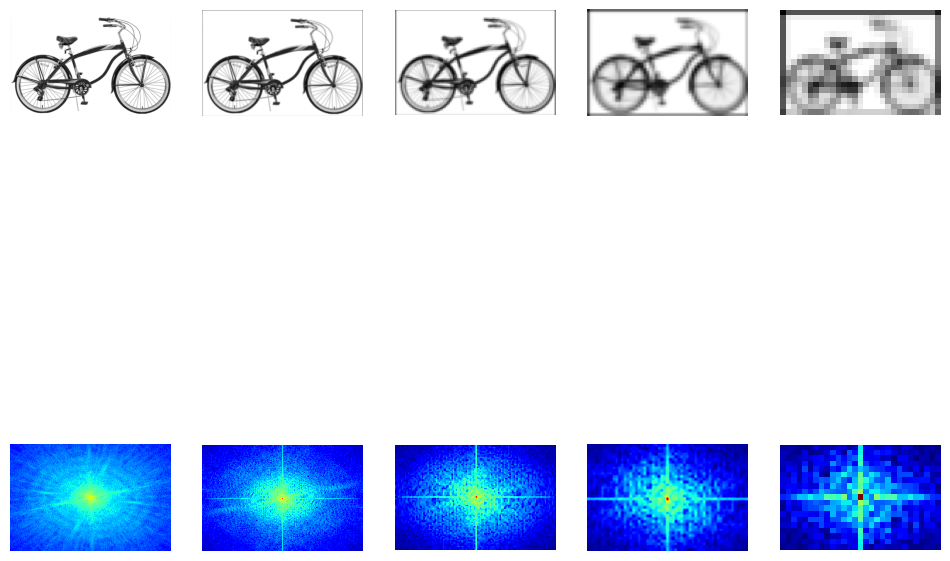

In [46]:
# Set number of pyramid levels
levels = 4

# Generate Gaussian and Laplacian pyramids
gaussian_pyr = gaussian_pyramid(image_gray, levels)

# Apply Fourier transform
fourier_pyr = fourier_transform(gaussian_pyr)

# Plot the results
plot_pyramids(gaussian_pyr, fourier_pyr)
